# Лабораторная работа № 4
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import cross_validate

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

## Задание 1

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [ ]:
df = pd.read_csv("bikes_rent.csv")
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

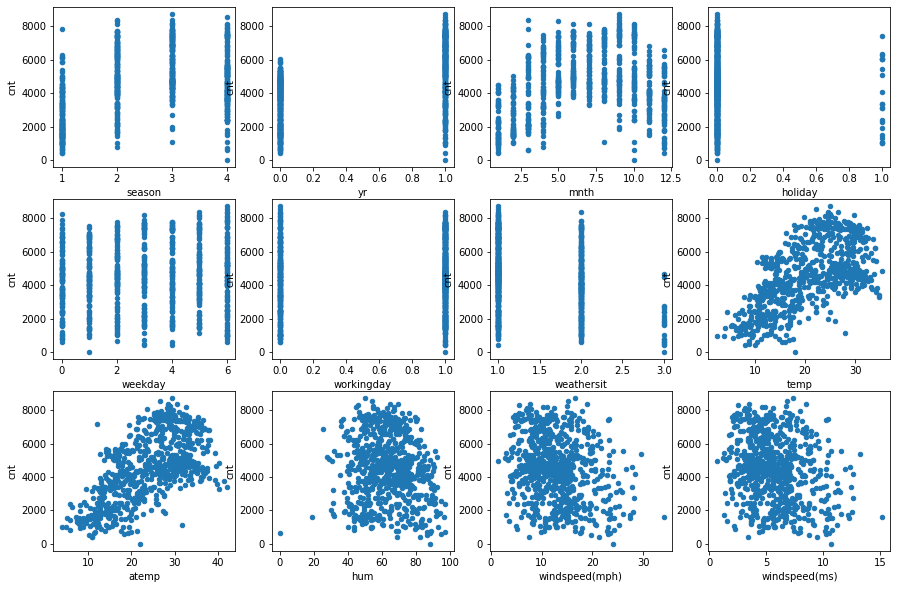

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__Блок 1. Ответьте на вопросы:__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: криволинейная зависимость
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp, atemp
  

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [ ]:
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
corrwith = df[df.columns[:-1]].corrwith(df.cnt)

print(corrwith)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [ ]:
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
corr = df[['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']].corr()

print(corr)

                    temp     atemp  ...  windspeed(ms)       cnt
temp            1.000000  0.991702  ...      -0.157944  0.627494
atemp           0.991702  1.000000  ...      -0.183643  0.631066
hum             0.126963  0.139988  ...      -0.248489 -0.100659
windspeed(mph) -0.157944 -0.183643  ...       1.000000 -0.234545
windspeed(ms)  -0.157944 -0.183643  ...       1.000000 -0.234545
cnt             0.627494  0.631066  ...      -0.234545  1.000000

[6 rows x 6 columns]


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [ ]:
# Выведите средние признаков
mean = df.mean()

print(mean)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [ ]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [ ]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

## Задание 3

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns
lr = LinearRegression()
lr.fit(X, y)
                                                                                                 
for coef in zip(df_shuffled.columns[:-1], lr.coef_):
    print(coef)                                                                                                                                                                                                                             

('season', 570.8675887934525)
('yr', 1021.9652921309369)
('mnth', -141.30438378580345)
('holiday', -86.75613647415624)
('weekday', 137.22482362623418)
('workingday', 56.39056950314733)
('weathersit', -330.2332887484121)
('temp', 367.47338726750786)
('atemp', 585.5559979631937)
('hum', -145.6063153911189)
('windspeed(mph)', 12458200269331.953)
('windspeed(ms)', -12458200269530.414)


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. 

## Задание 4

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [ ]:
from sklearn.linear_model import Lasso, Ridge

In [ ]:
# Обучите линейную модель с L1-регуляризацией и выведите веса
lasso = Lasso()
lasso.fit(X, y)

for coef in zip(df_shuffled.columns[:-1], lasso.coef_):
    print(coef)

('season', 560.2416160308869)
('yr', 1019.4634940657196)
('mnth', -128.73062703678752)
('holiday', -86.15278133371116)
('weekday', 137.34789390496314)
('workingday', 55.212370641356685)
('weathersit', -332.3698569623484)
('temp', 376.3632362096995)
('atemp', 576.5307935045503)
('hum', -144.1291550034858)
('windspeed(mph)', -197.13968940248557)
('windspeed(ms)', -2.8050167469807684e-08)


In [ ]:
# Обучите линейную модель с L2-регуляризацией и выведите веса
ridge = Ridge()
ridge.fit(X, y)

for coef in zip(df_shuffled.columns[:-1], ridge.coef_):
    print(coef)

('season', 563.0645722520175)
('yr', 1018.9483787875301)
('mnth', -131.873320282477)
('holiday', -86.74609799709219)
('weekday', 138.0051111787191)
('workingday', 55.90311037506478)
('weathersit', -332.34978849907395)
('temp', 386.4578891919065)
('atemp', 566.3470470600686)
('hum', -145.07132729867178)
('windspeed(mph)', -99.25944108179063)
('windspeed(ms)', -99.25944115434177)


## Задание 5

Получите предсказания значений на регрессорах Lasso и Ridge, используя сначала тестовую, а затем обучающую часть выборки. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

test_pred_lasso = lasso.predict(X_test)
test_pred_ridge = ridge.predict(X_test)

train_pred_lasso = lasso.predict(X_train)
train_pred_ridge = ridge.predict(X_train)

Оцените качество полученных моделей по R2

In [ ]:
from sklearn import metrics

r2_test_lasso = metrics.r2_score(y_test, test_pred_lasso)
r2_train_lasso = metrics.r2_score(y_train, train_pred_lasso)
print(f'r2_test_lasso: {r2_test_lasso}', f'r2_train_lasso: {r2_train_lasso}')

r2_test_ridge = metrics.r2_score(y_test, test_pred_ridge)
r2_train_ridge = metrics.r2_score(y_train, train_pred_ridge)
print(f'r2_test_ridge: {r2_test_ridge}', f'r2_train_ridge: {r2_train_ridge}')

r2_test_lasso: 0.7823117991546827 r2_train_lasso: 0.8074952867576204
r2_test_ridge: 0.7822645983550609 r2_train_ridge: 0.8075180494307133


Сделайте выводы о переобучении модели

In [ ]:
# Разница оценок в тестовой и обучающей выборках незначительна, что говорит об отсутствии переобучения.
# Модели относительно хорошего качества, т.к. коэффициент детерминации r2 больше 0.5